# Machine Learning for Assessing Brush Fire Risk in The United States

## Import required packages

In [1]:
# !pip install geopandas shapely

In [2]:
#Importing required packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import csv
import xarray as xr
import zarr
import fsspec
import cartopy.crs as ccrs
import glob as glob
import netCDF4 as nc
from netCDF4 import Dataset
from scipy.stats import skew,stats
import bottleneck
import gcsfs
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore") 

# import geopandas as gpd
# from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## Fire data

In [3]:
# Directory containing the CSV files
directory = './'

# Create a dictionary to hold the dataframes. The keys will be years.
modis_data = {}
all_dataframes = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    # Use a regex to match the pattern "modis" followed by a year and ending with "United_States.csv"
    match = re.match(r'modis_(\d{4})_United_States.csv', filename)
    if match:
        # Extract the year from the matched filename
        year = match.group(1)
        # Load the CSV file into a dataframe
        df = pd.read_csv(os.path.join(directory, filename))
        # Store the dataframe in the dictionary with the year as the key
        modis_data[year] = df
        all_dataframes.append(df)
        
all_in_one_data = pd.concat(all_dataframes, ignore_index=True)

In [4]:
modis_2000 = modis_data['2000']
modis_2001 = modis_data['2001']
modis_2002 = modis_data['2002']
modis_2003 = modis_data['2003']
modis_2004 = modis_data['2004']
modis_2005 = modis_data['2005']
modis_2006 = modis_data['2006']
modis_2007 = modis_data['2007']
modis_2008 = modis_data['2008']
modis_2009 = modis_data['2009']
modis_2010 = modis_data['2010']
modis_2011 = modis_data['2011']
modis_2012 = modis_data['2012']
modis_2013 = modis_data['2013']
modis_2014 = modis_data['2014']
modis_2015 = modis_data['2015']
modis_2016 = modis_data['2016']
modis_2017 = modis_data['2017']
modis_2018 = modis_data['2018']
modis_2019 = modis_data['2019']
modis_2020 = modis_data['2020']
modis_2021 = modis_data['2021']
modis_2022 = modis_data['2022']

In [5]:
print(all_in_one_data.iloc[0])
print(type(all_in_one_data))
all_in_one_data.head()

latitude         38.5422
longitude       -78.3047
brightness         304.8
scan                 2.8
track                1.6
acq_date      2000-11-01
acq_time             250
satellite          Terra
instrument         MODIS
confidence            23
version              6.2
bright_t31         280.9
frp                 40.3
daynight               N
type                   0
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,38.5422,-78.3047,304.8,2.8,1.6,2000-11-01,250,Terra,MODIS,23,6.2,280.9,40.3,N,0
1,38.5563,-78.3084,309.4,2.8,1.6,2000-11-01,250,Terra,MODIS,70,6.2,280.4,54.5,N,0
2,38.5451,-78.3107,309.9,2.8,1.6,2000-11-01,250,Terra,MODIS,79,6.2,280.7,58.8,N,0
3,38.5586,-78.3170,302.3,2.8,1.6,2000-11-01,250,Terra,MODIS,45,6.2,279.8,36.0,N,0
4,31.3393,-89.9124,304.9,1.0,1.0,2000-11-01,427,Terra,MODIS,62,6.2,287.5,8.5,N,0


In [6]:
modis_2000

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,38.5422,-78.3047,304.8,2.8,1.6,2000-11-01,250,Terra,MODIS,23,6.2,280.9,40.3,N,0
1,38.5563,-78.3084,309.4,2.8,1.6,2000-11-01,250,Terra,MODIS,70,6.2,280.4,54.5,N,0
2,38.5451,-78.3107,309.9,2.8,1.6,2000-11-01,250,Terra,MODIS,79,6.2,280.7,58.8,N,0
3,38.5586,-78.3170,302.3,2.8,1.6,2000-11-01,250,Terra,MODIS,45,6.2,279.8,36.0,N,0
4,31.3393,-89.9124,304.9,1.0,1.0,2000-11-01,427,Terra,MODIS,62,6.2,287.5,8.5,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,26.6922,-80.8788,301.0,2.8,1.6,2000-12-31,1656,Terra,MODIS,41,6.2,285.1,24.0,D,0
3777,26.7034,-80.8811,300.1,2.8,1.6,2000-12-31,1656,Terra,MODIS,26,6.2,285.5,22.5,D,0
3778,26.6977,-80.8537,304.6,2.8,1.6,2000-12-31,1656,Terra,MODIS,56,6.2,282.9,35.9,D,0
3779,38.3211,-108.8656,300.0,1.1,1.0,2000-12-31,1832,Terra,MODIS,20,6.2,279.3,6.7,D,0


## Plot

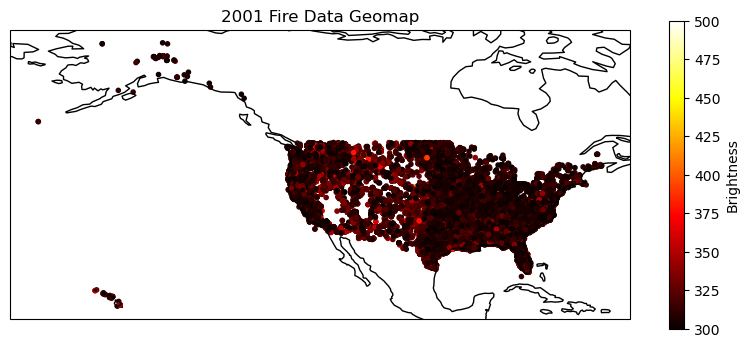

In [23]:
df = pd.DataFrame(modis_2001)

# Plotting the data
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Plotting each fire data point
plt.scatter(df['longitude'], df['latitude'], 
            c=df['brightness'], 
            cmap='hot', 
            marker='.',
            transform=ccrs.PlateCarree())

plt.title("2001 Fire Data Geomap")
plt.colorbar(label='Brightness')

plt.show()

TypeError: Input z must be 2D, not 1D

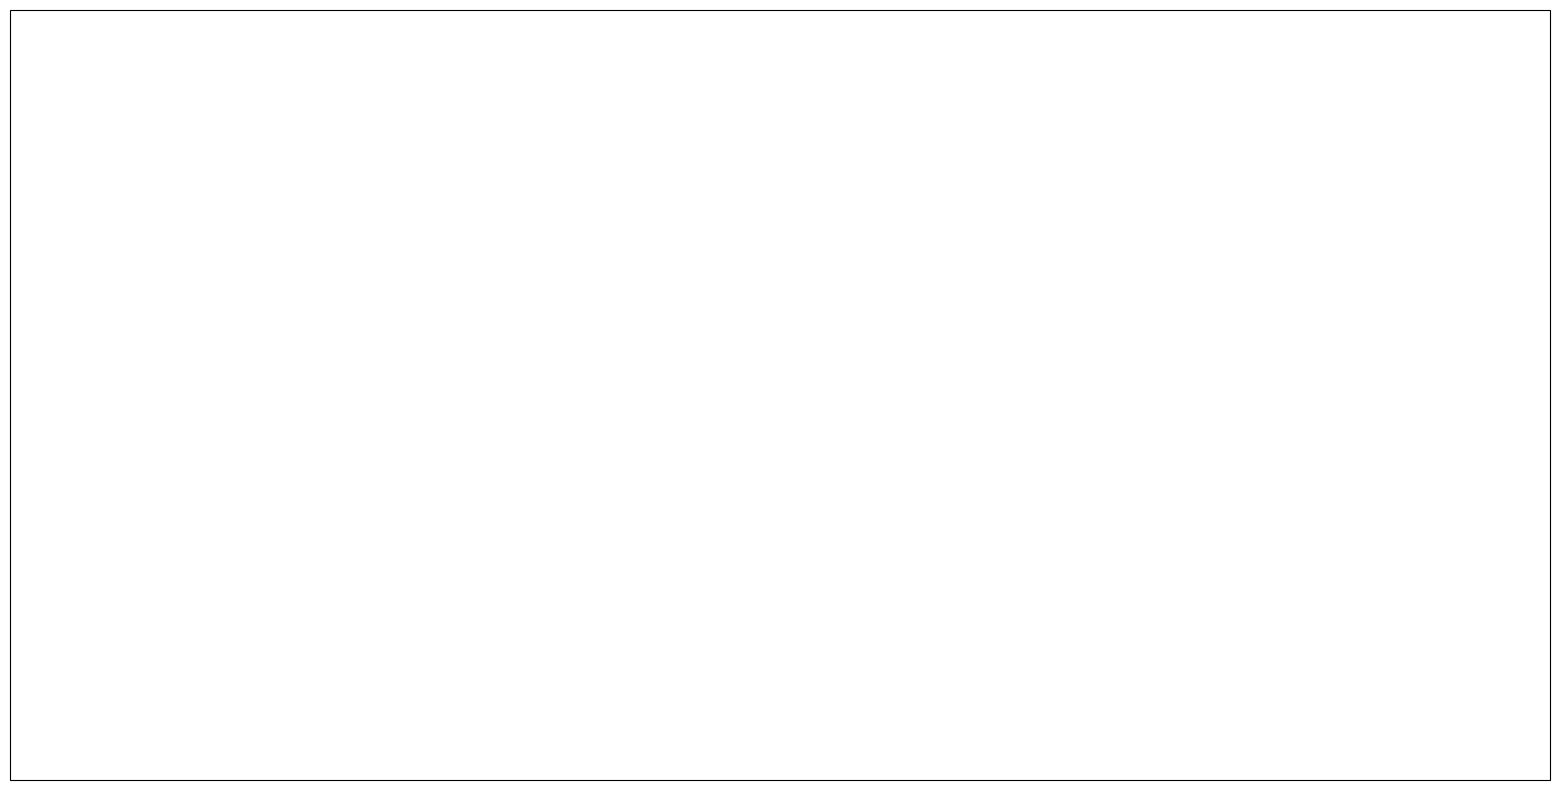

In [10]:
lon=modis_2001.longitude
lat=modis_2001.latitude
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(0, 13, 1)
# filled contours
cf = ax.contourf(lon, lat, modis_2001.bright_t31 , cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, modis_2001, colors='k', linewidths=1,levels=np.arange(0, 13, 2),
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label('mm/day', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('Annual Mean Precipitation (present-day)', loc='left', fontsize=26)
plt.title('MRI-AGCM3-2-S, 1981-2010 climo', loc='right', fontsize=18)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 140, 160, 180, -160, -140, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
# plt.savefig('prcp_anm_MRI-AGCM3-2-S_present.pdf')  
plt.show()